In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 패키지 불러오기

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import sin, cos, sqrt, atan2, radians, degrees
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from tqdm import tqdm

## 데이터 불러오기

In [73]:
train=pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/sample_submission.csv')

In [74]:
print('train shape :', train.shape)
print('test shape :',test.shape)

train shape : (1458644, 11)
test shape : (625134, 9)


- ID - 각 여행에 대한 고유 식별자
- vendor_id - 여행 기록과 관련된 공급자를 나타내는 코드
- pickup_datetime - 미터가 종사한 날짜 및 시간
- dropoff_datetime - 미터가 분리된 날짜 및 시간
- passenger_count - 차량의 승객 수 (운전자가 값을 입력)
- pickup_longitude - 미터가 종사하는 경도
- pickup_latitude - 미터가 종사하는 위도
- dropoff_longitude - 미터가 분리 된 경도
- dropoff_latitude - 미터가 분리 된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 공급 업체에 보내기 전에 여행 기록이 차량 메모리에 보관되었는지 여부를 나타냅니다.-Y = 저장 및 전달; N = 저장 및 전진 여행 아님
- trip_duration - 초 여행의 기간

In [75]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [76]:
print('########### train ##################')
print(train.info())

print('########### test ##################')
print(test.info())

########### train ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
########### test ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data

In [77]:
print('############# train 결측치 ##############')
print(train.isnull().sum())

print('############# test 결측치 ##############')
print(test.isnull().sum())

############# train 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
############# test 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


- 결측치는 모든 데이터에 없다.

In [78]:
print('####################### train ##################')
display(train.describe())

print('###################### test ###################')
display(test.describe())

####################### train ##################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


###################### test ###################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [79]:
# 나중에 month. day, hour, weekday를 추출하기 위해서 datetime으로 바꿔준다.
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# trip_duration을 target으로 바꿔준다.
train=train.rename(columns = {'trip_duration':'target'})

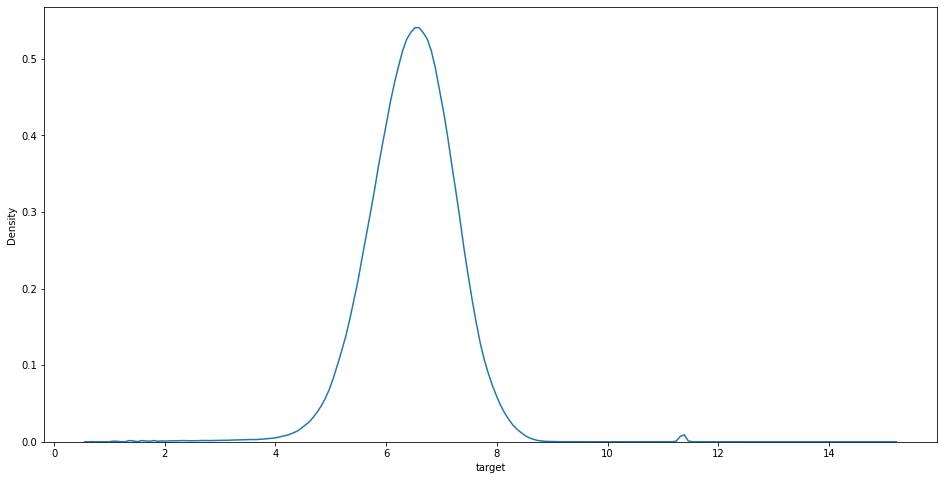

In [80]:
# target에 정규화를 시켜주고 분석을 진행해 주자.
plt.figure(figsize = (16,8))
sns.kdeplot(train['target'].apply(lambda x:np.log1p(x)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


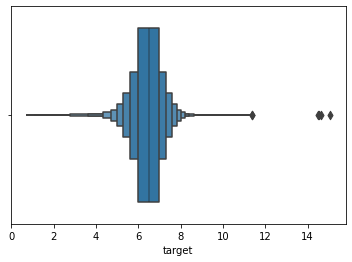

In [81]:
# target의 이상치를 제거한다.
sns.boxenplot(train['target'].apply(lambda x:np.log1p(x)))

In [82]:
# 회귀분석은 정규화를 해준 이후에 데이터를 분석해야 하므로 target변수에 log를 씌운 이후 나중에 풀어주도록 하자.
train['log_target'] = train['target'].apply(lambda x: np.log1p(x))

In [83]:
def get_outlier(df=None, column=None, weight=4.0):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

delete_index = get_outlier(df = train, column = 'log_target', weight = 3)
train.drop(delete_index, axis = 0, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


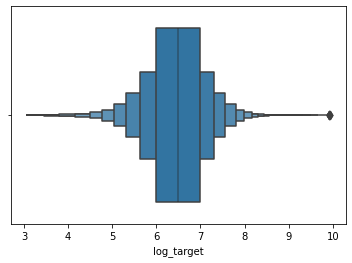

In [84]:
# 이상치를 제거한 이후 boxenplot을 그려본다.
sns.boxenplot(train['log_target'])

# id

In [85]:
# id의 앞에있는 id라는 값을 제거해주기 위해서 lambda x:x[2:]를 사용하여 숫자만 추출한다.
train['id']=train['id'].apply(lambda x:x[2:])
train['id']=train['id'].astype('int')

test['id'] = test['id'].apply(lambda x: x[2:])
test['id'] = test['id'].astype('int')

In [86]:
# id의 min과 max를 확인해 본다.
print(train['id'].min(), train['id'].max())
print(test['id'].min(), test['id'].max())

1 4000000
2 3999997


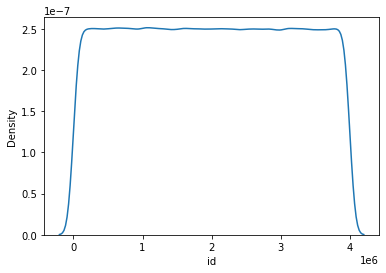

In [87]:
# 특정한 분포를 찾을 수 없으므로 이 데이터는 제거 해 주도록 하자.
sns.kdeplot(data = train, x = 'id')

## vendor_id

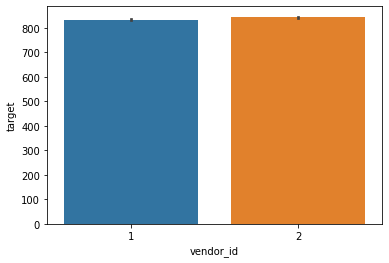

In [88]:
# vendor_id를 target으로 비교해주자.
sns.barplot(data = train, x = 'vendor_id', y = 'target')

- 이 데이터의 경우 설명도 나와 있지 않기 때문에 나중에 다른 변수와 비교할 때 사용해야 겠다.

## passenger_count

In [89]:
# passenger_count는 test에만 7과 8이 없다.
print('train의 passenger_count')
print(train['passenger_count'].value_counts())
print('test의 passenger_count')
print(test['passenger_count'].value_counts())

train의 passenger_count
1    1029359
2     209701
5      77786
3      59702
6      48162
4      28319
0         29
9          1
8          1
7          1
Name: passenger_count, dtype: int64
test의 passenger_count
1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64


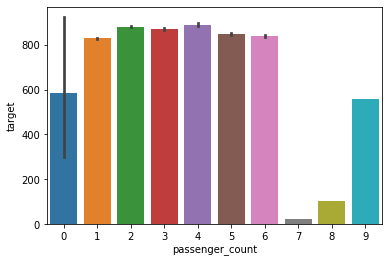

In [90]:
# train의 passenger_count를 target변수와 비교해 본다.
sns.barplot(data = train, x = 'passenger_count', y = 'target')

- 0명을 태웠다는 말은 무슨말일까?
- 일단 test셋에 7과 8이 없음으로 passenger_count의 변수는 지워주도록 하자.

## pickup_datetime

In [91]:
# datetime이라는 함수를 만들어서 월, 일, 시간의 컬럼을 만들어 준다.
def datetime(df, column):
    df['month'] = df[column].dt.month
    df['day'] = df[column].dt.day
    df['hour'] = df[column].dt.hour
    return df

In [92]:
# train과 test에 적용시켜준다.
train=datetime(df = train, column = 'pickup_datetime')
test=datetime(df = test, column = 'pickup_datetime')

In [93]:
# 주말과 평일을 나누어서 데이터를 분석해 보자.
train['weekday'] = train['pickup_datetime'].apply(lambda x:x.weekday())
train['weekday']=train['weekday'].apply(lambda x: 1 if x > 4 else 0)

test['weekday'] = test['pickup_datetime'].apply(lambda x:x.weekday())
test['weekday']=test['weekday'].apply(lambda x: 1 if x > 4 else 0)

### 평일과 공휴일의 차이

Text(0.5, 1.0, 'weekday vs target')

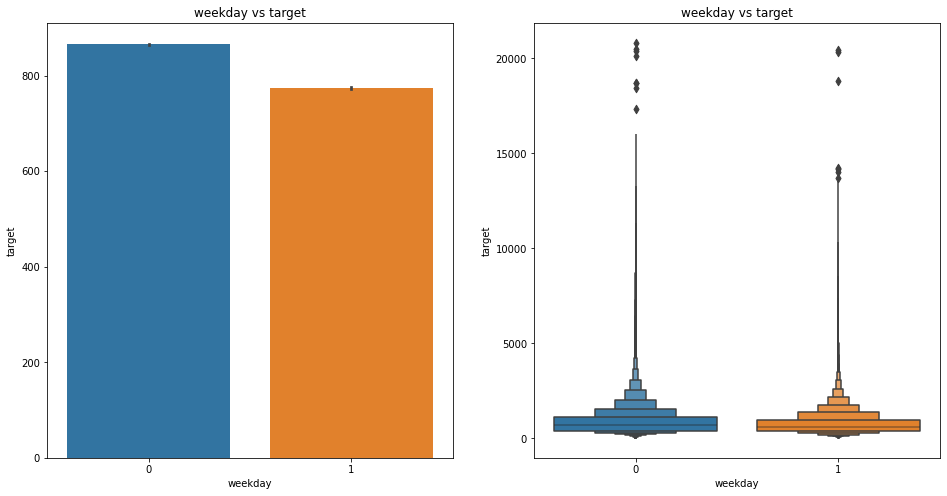

In [94]:
# 평일과 주말의 데이터를 target으로 비교해 본다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('weekday vs target')

sns.boxenplot(data = train, x = 'weekday', y = 'target', ax = ax[1])
ax[1].set_title('weekday vs target')

- 사람들은 평일에 택시를 더 많이 타는 것을 알 수있다.

### 월별로 차이

Text(0.5, 1.0, 'month vs target')

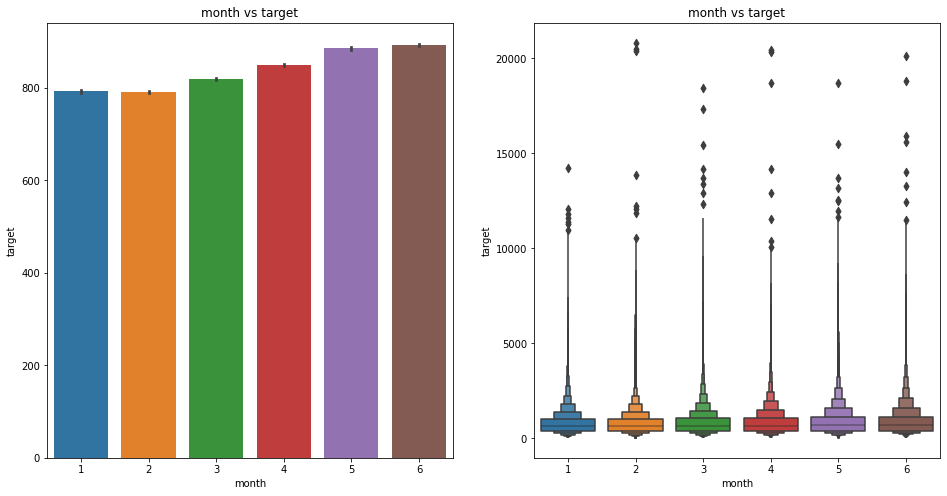

In [95]:
# 월별로 target변수와 비교해준다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('month vs target')

sns.boxenplot(data = train, x = 'month', y = 'target', ax = ax[1])
ax[1].set_title('month vs target')

- 매 달마다 택시를 타는 사람이 늘어나고 있다.

### 일별로 차이

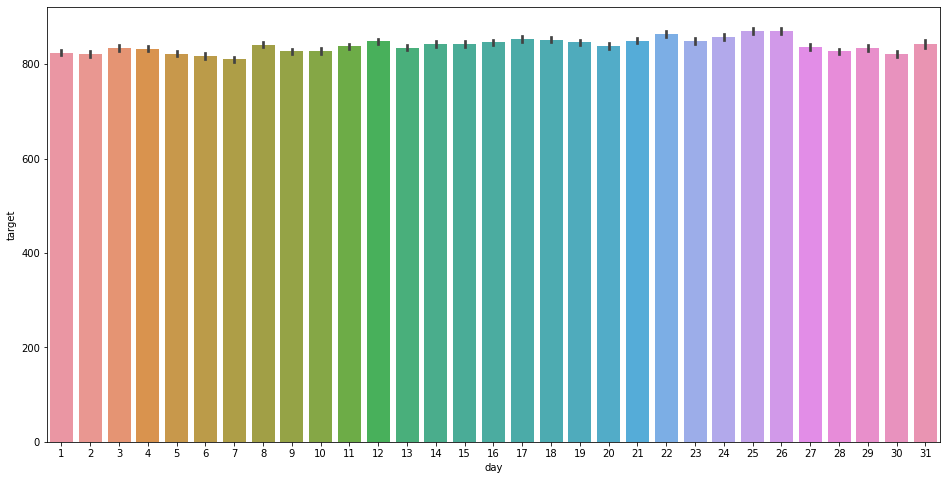

In [96]:
# 일별로 차이를 확인한다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target')

- 일별로는 다른 차이점을 발견하지 못했다.

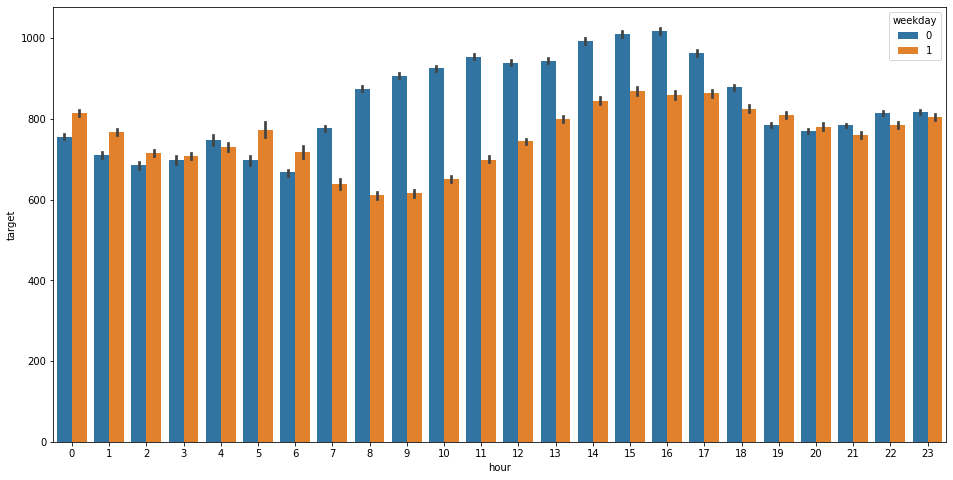

In [97]:
# 시간별로 target변수를 weekday별로 비교해 준다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')

- 시간별로 공휴일인지 아닌지는 차이가 있는 것 같다.

## 위도 경도를 이용해 거리 구하기

In [98]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'log_target', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [99]:
# haversine 거리 구하는 함수 만들기
def haversine(s_lat,s_lng,e_lat,e_lng):
    # approximate radius of earth in km
#     R = 6373.0 #/1.60934 마일로 계산하려면 나누기
    R = 6373.1 #마일로 계산하려면 나누기

    s_lat = np.deg2rad(s_lat)                    
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return 2 * R * np.arcsin(np.sqrt(d))
    

# train과 test에 적용시켜주기
train['distance'] = haversine(train['pickup_latitude'],train['pickup_longitude'],train['dropoff_latitude'],train['dropoff_longitude'])


test['distance'] = haversine(test['pickup_latitude'],test['pickup_longitude'],test['dropoff_latitude'],test['dropoff_longitude'])

In [100]:
# haversine을 짯지만 너무 느린관계로 쓰지 않는다.
# from tqdm import tqdm

# def haversine1(df = None):
#     for i in tqdm(df.index):
#         df.loc[i,'distance'] = haversine((df.loc[i,'pickup_longitude'],df.loc[i,'pickup_latitude']),
#                                          (df.loc[i,'dropoff_longitude'],df.loc[i,'dropoff_latitude']), unit = 'm')
#     return df

# distance_train=haversine1(df = train)
# distance_train=pd.DataFrame(distance_train)

# distance_test = haversine1(df = test)
# distance_test = pd.DataFrame(distance_test)

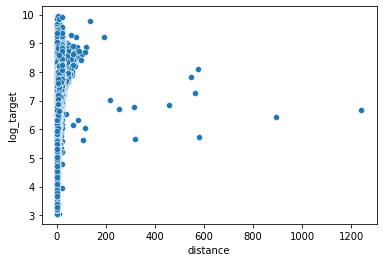

In [101]:
# distance와 target의 분포도를 그려본다.
sns.scatterplot(data =  train, x = 'distance', y = 'log_target')

In [102]:
# 로그를 이용하여 정규화 시켜주기
train['distance'] = train['distance'].apply(lambda x: np.log1p(x))
test['distance'] = test['distance'].apply(lambda x:np.log1p(x))

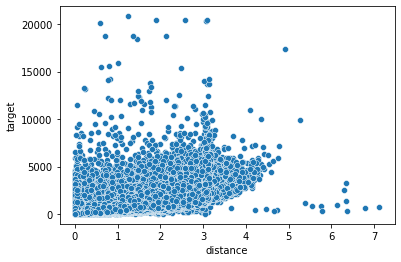

In [103]:
sns.scatterplot(data = train, x = 'distance',y = 'target')

## 평균 속도로 결측치 제거

In [104]:
# train에만 있는 평균속도를 구해준다.
train['target_hour'] = train['target'].apply(lambda x:x/3600)
train['velocity'] = train['distance']/train['target_hour']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


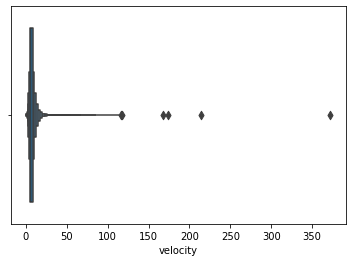

In [105]:
#IQR을 사용하여 데이터를 없애주자.
sns.boxenplot(train['velocity'])

In [106]:
# iqr로 이상치 제거를 해주자.
def get_outlier(df=None, column=None, weight=3.0):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx = get_outlier(df=train, column='velocity', weight=3.5)
train.drop(outlier_idx, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


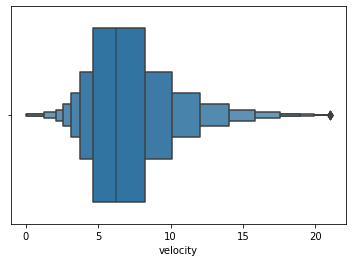

In [107]:
# IQR로 이상치를 제거한 이후에 boxenplot을 그려본다.
sns.boxenplot(train['velocity'])

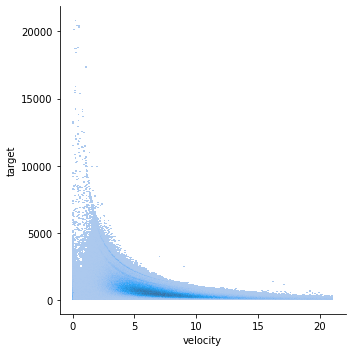

In [108]:
# target에 결측치가 많다는 생각이 든다.
sns.displot(data = train, x = 'velocity', y = 'target')

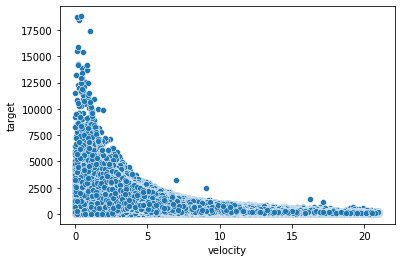

In [109]:
# target이 2000이상인 것들만 그래프를 그려본다.
sns.scatterplot(data = train[train['target'] < 20000], x = 'velocity', y = 'target')

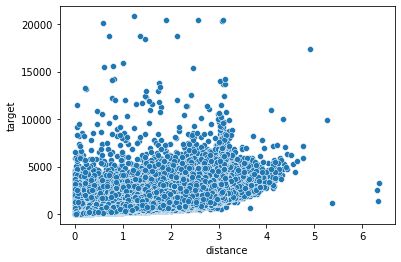

In [110]:
# 거리와 target의 그래프를 그려봤다.
sns.scatterplot(data = train, x = 'distance', y = 'target')

Text(0.5, 1.0, 'dropoff')

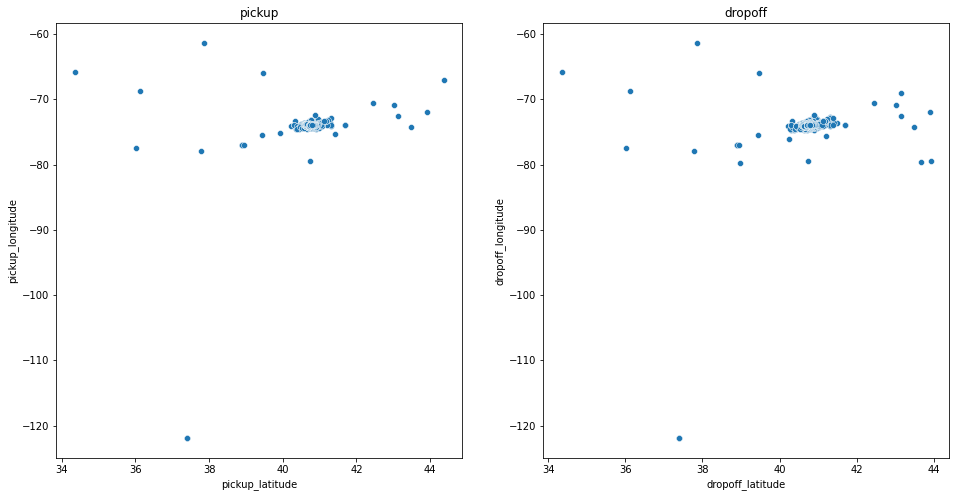

In [111]:
# train의 pickup과 dropoff를 scatterplot으로 그려본다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.scatterplot(data = train, x = 'pickup_latitude', y = 'pickup_longitude', ax = ax[0])
ax[0].set_title('pickup')

sns.scatterplot(data = train, x = 'dropoff_latitude', y = 'dropoff_longitude', ax = ax[1])
ax[1].set_title('dropoff')

Text(0.5, 1.0, 'dropoff')

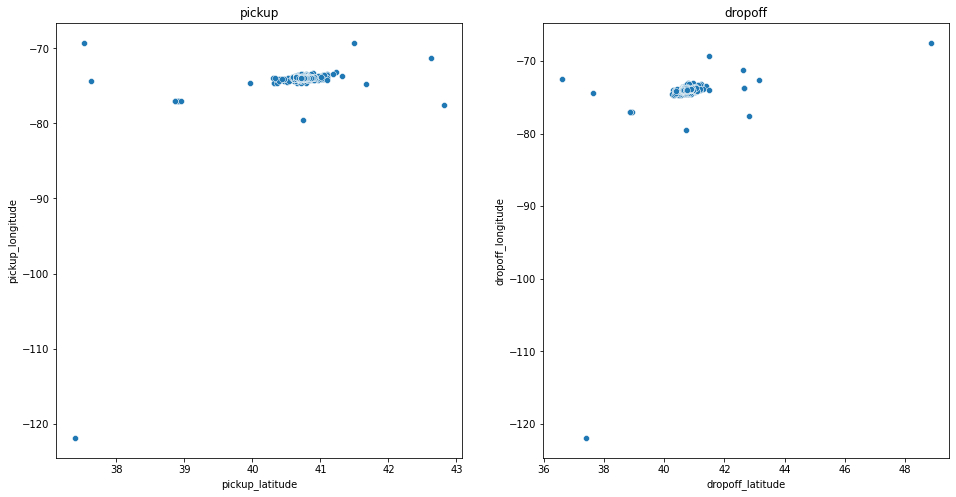

In [112]:
# test의 pickup과 dropoff를 scatterplot으로 그려본다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.scatterplot(data = test, x = 'pickup_latitude', y = 'pickup_longitude', ax = ax[0])
ax[0].set_title('pickup')

sns.scatterplot(data = test, x = 'dropoff_latitude', y = 'dropoff_longitude', ax = ax[1])
ax[1].set_title('dropoff')

In [113]:
# test데이터 셋에 맞춰서 데이터 잘라주기
# pickup은 latitude 36 43 longitude -130 -75
# dropoff는 latitude 36~48 longitude -130 ~ -65
delete_index0 = train[(train['pickup_latitude'] <37) & (train['pickup_latitude'] > 43)].index
delete_index1 = train[(train['pickup_longitude'] < -130) & (train['pickup_longitude'] > -75)].index
delete_index2 = train[(train['dropoff_latitude'] < 36) & (train['dropoff_latitude'] > 48)].index
delete_index3 = train[(train['dropoff_longitude'] < -130) & (train['dropoff_longitude'] > -65)].index

delete_index = [delete_index0, delete_index1, delete_index2, delete_index3]

outlier_idx = []
for i in delete_index:
  for j in i:
    outlier_idx.append(j)

train.drop(outlier_idx, axis = 0, inplace = True)

In [114]:
# KMeans 불러오기
from sklearn.cluster import MiniBatchKMeans

# k-means clustering 실행
# pickup
kmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 500,random_state= 42).fit(train[['pickup_latitude','pickup_longitude']])
train['pickup_clustering']= kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test['pickup_clustering'] = kmeans.predict(test[['pickup_latitude','pickup_longitude']])

# dropoff
kmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 500).fit(train[['dropoff_latitude','dropoff_longitude']])
train['dropoff_clustering']= kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])
test['dropoff_clustering'] = kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

## store_and_fwd_flag

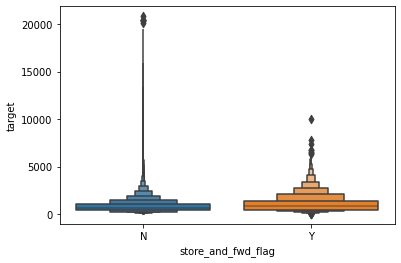

In [115]:
# store_and_fwd_flag를 target의 변수와 비교해 본다. 
sns.boxenplot(data = train, x = 'store_and_fwd_flag', y = 'target')

- Y가 N보다 더 높은 시간은 나타낸다.

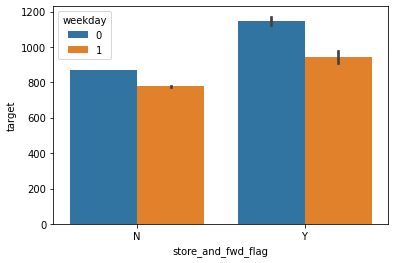

In [116]:
# store_and_fwd_flag와 target을 weekday별로 살펴본다.
sns.barplot(data = train, x = 'store_and_fwd_flag', y = 'target', hue = 'weekday')

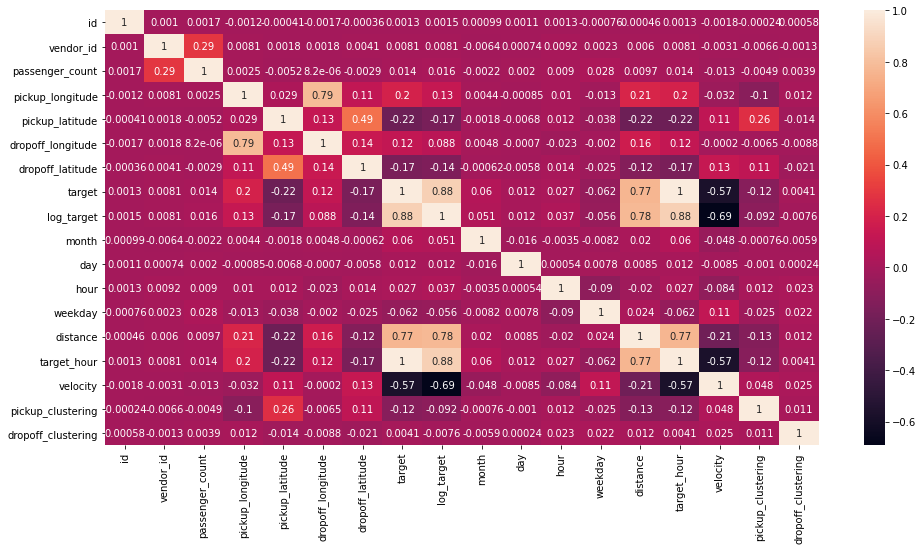

In [117]:
# 상관관계를 찍어서 더 전처리할 변수를 찾아준다.
plt.figure(figsize = (16,8))
train_corr=train.corr()
sns.heatmap(train_corr, annot = True)

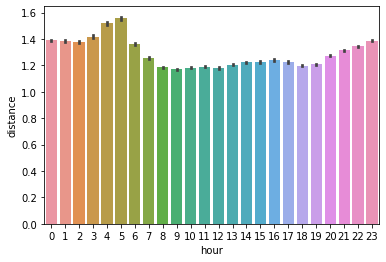

In [118]:
# 3~5시 사이에 높은 이동량을 보인다.
sns.barplot(data = train, x = 'hour', y = 'distance')

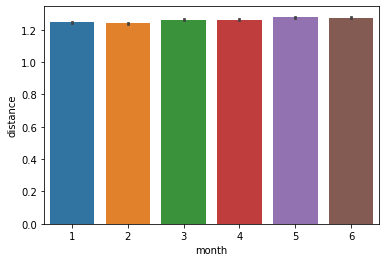

In [119]:
# 눈이 올 때 1월과 2월에 거리가 더 적다.
sns.barplot(data = train, x = 'month', y = 'distance')

### 가정 1 : 1월과 2월에는 추운 날씨 때문에 적은 거리라도 택시를 탈 것이다.

![%EC%BA%A1%EC%B2%98.PNG](attachment:%EC%BA%A1%EC%B2%98.PNG)

- 변수 0 :1~2월은 겨울인 달
- 변수 1 :3~6월은 겨울이 아닌 달

In [120]:
# 겨울인 1~2월에는 사람들이 적은 거리도 택시를 탈 것이다.
train['cold'] = 1
train.loc[(train['month'] == 1) | (train['month'] == 2), 'cold'] = 0

test['cold'] = 1
test.loc[(test['month'] == 1) | (test['month'] == 2), 'cold'] = 0

train.cold.value_counts()

1    980467
0    463179
Name: cold, dtype: int64

Text(0.5, 1.0, 'cold VS log_target')

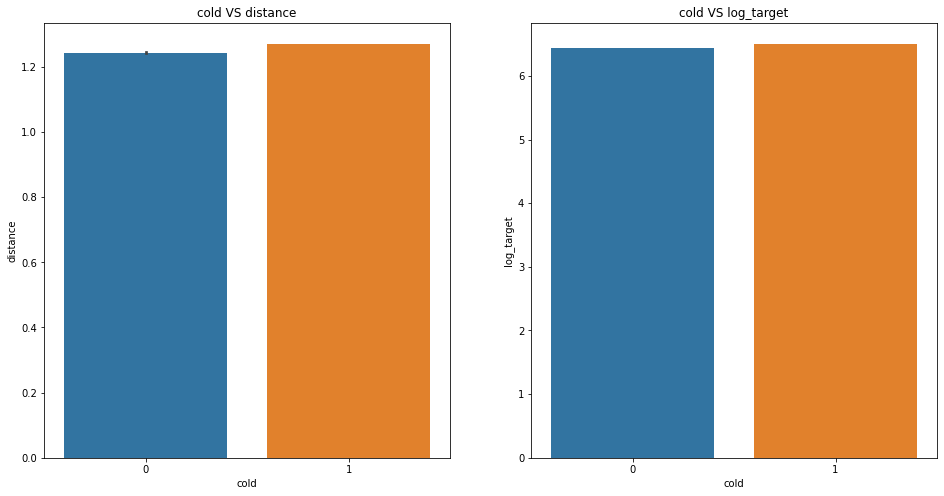

In [121]:
# 거리와 target의 상관관계가 높은데 둘다 똑같이 0에서 적은 수를 나타내는 것을 확인하고 변수로 써야 겠다고 생각했습니다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'cold', y = 'distance', ax = ax[0])
ax[0].set_title('cold VS distance')

sns.barplot(data = train, x = 'cold', y = 'log_target', ax = ax[1])
ax[1].set_title('cold VS log_target')

## 모델링

In [122]:
!pip install catboost

In [123]:
# 모델링에 사용할 패키지를 불러온다.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [124]:
dummies=['vendor_id','store_and_fwd_flag','weekday','cold','pickup_clustering','dropoff_clustering','month','hour']
# train 데이터 더미화
train_data = pd.get_dummies(data = train[dummies], columns = dummies)
train_data = pd.concat([train_data,train[['distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]],axis = 1)
  
# test 데이터 더미화
test_dummies=pd.get_dummies(test[dummies], columns = dummies)
test_data = test_dummies
test_data = pd.concat([test_data,test[['distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]],axis = 1)

In [125]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [127]:
# # xgbregressor 파라미터 최적화 수행해준다.
# from sklearn.metrics import make_scorer, mean_squared_error
# params = {
#         'min_child_weight': [8],
#         'gamma': [0.1], 
#         'subsample': [0.8],
#         'max_depth': [16]  
#         }
# cv = KFold(n_splits= 5, shuffle = True, random_state = 42)
# xgb = XGBRegressor(random_state = 42, tree_method = 'gpu_hist')
# xgb_gcv = GridSearchCV(estimator = xgb, param_grid = params, cv = cv, scoring= 'neg_mean_squared_log_error')
# xgb_gcv.fit(train_data,train['log_target'])  
# print(xgb_gcv.best_params_) 
# model = xgb_gcv.best_estimator_
# xgb_pred = model.predict(test_data)

# # # 예측값을 로그 씌우기 전으로 바꿔준다.
# xgb_pred = pd.DataFrame(xgb_pred, columns = ['xgb_pred'])
# xgb_pred = xgb_pred['xgb_pred'].apply(lambda x: np.exp(x) - 1)


# submission['trip_duration'] = xgb_pred
# submission.to_csv("submission.csv", index_label=False, index = False)

In [128]:
# catboost 파라미터 최적화를 수행해준다.
# params = {'depth': [10], 'iterations': [1000], 'l2_leaf_reg': [60], 'learning_rate': [0.1]}

# cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
# cat = CatBoostRegressor(task_type = 'GPU')
# cat_gcv = GridSearchCV(estimator = cat, param_grid = params, scoring = 'neg_mean_squared_log_error')
# cat_gcv.fit(train_data, train['log_target'])
# print(cat_gcv.best_params_)

# model = cat_gcv.best_estimator_
# cat_pred = model.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
# cat_pred = pd.DataFrame(cat_pred, columns = ['cat_pred'])
# cat_pred  = cat_pred['cat_pred'].apply(lambda x: np.exp(x) - 1)

# submission['trip_duration'] = cat_pred
# submission.to_csv("submission.csv", index_label=False, index = False)
# print(submission)

# 0.42758

In [129]:

# LGBMRegressor 파라미터 최적화를 수행해준다.
# param_grid = {
#     'max_depth': [12], 
#     'learning_rate': [0.1],
#     'n_estimators':[250],
#     }

# cv = KFold(n_splits= 5, shuffle= True)
# model = LGBMRegressor(random_state =42)
# lgb_gcv = GridSearchCV(estimator = model, param_grid= param_grid, cv = cv, n_jobs= -1, scoring = 'neg_mean_squared_log_error')
# lgb_gcv.fit(train_data, train['log_target'])
# print(lgb_gcv.best_params_)
  
# model = lgb_gcv.best_estimator_
# lgb_pred  = model.predict(test_data)

# # print(lgb_gcv.best_params_)
# # 예측값을 로그 씌우기 전으로 바꿔준다.
# lgb_pred = pd.DataFrame(lgb_pred, columns = ['lgb_pred'])
# lgb_pred = lgb_pred['lgb_pred'].apply(lambda x: np.exp(x) - 1)


# submission['trip_duration'] = lgb_pred
# submission.to_csv("submission.csv", index_label=False, index = False)

In [131]:
# # 모델들을 dict를 사용하여 모아준다.
models = {'xgb': XGBRegressor(min_child_weight = 8, gamma = 0.1, subsample = 0.8,  max_depth = 16, tree_method = 'gpu_hist', random_state = 42),
        'Ridge':Ridge(), 'Lasso':Lasso(), 'lgb': LGBMRegressor(max_depth = 12,learning_rate = 0.1, n_estimators = 250, random_state = 42), 'cat':CatBoostRegressor(learning_rate = 0.1, iterations = 1000, l2_leaf_reg = 60, depth = 10, task_type = 'GPU')}

# train과 test로 쌓을 데이터를
train_final_value = pd.DataFrame([])
test_final_value = pd.DataFrame([])
X_train, X_test, y_train, y_test = train_test_split(train_data, train['log_target'], test_size = 0.2, random_state = 42)

# 데이터 예측값들 쌓아보기
for model_name, model in models.items():
  print(model_name, model)
  model = model.fit(X_train, y_train)
  train_pred = model.predict(X_test)
  test_pred = model.predict(test_data)

  train_final_value[model_name] = train_pred
  test_final_value[model_name] = test_pred

# xgbf를 메타모델로 사용하고 이것 또한 gridsearchcv를 이용하여 파라미터 최적화 이후 분석을 진행한다.
param_grid ={'gamma': [0.1] ,'max_depth': [10], 'min_child_weight': [6], 'subsample': [0.8]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
model = XGBRFRegressor(tree_method = 'gpu_hist', random_state = 42)
xgbf_gcv = GridSearchCV(estimator= model, param_grid = param_grid, n_jobs = -1, cv = cv, scoring = 'neg_mean_squared_log_error')
xgbf_gcv.fit(train_final_value, y_test)
model = xgbf_gcv.best_estimator_
y_pred = model.predict(test_final_value)

y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)
print(submission)

# 0.44074

xgb XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=16, min_child_weight=8, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)
[02:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ridge Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Lasso Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
lgb LGBMRegress

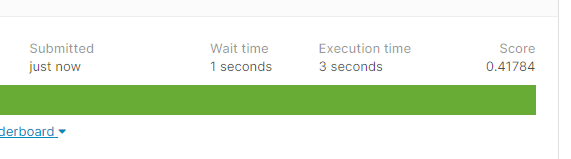